Notebook on Statistical Testing by João Pedro Apolonio. Here we will focus on:

- Statistical hypothesis testing
- Confidence intervals

Based on exercises by Julien Gagneur

In [2]:
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels as stats
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


In [3]:
#Genotype indicates if the genome of the yeast is artificial(lab strain) or wild(seen in nature).
genotype = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Data science TUM/Data/extdata/eqtl/genotype.txt", sep='\t')
genotype = pd.melt(genotype, id_vars = "strain", var_name = "marker", value_name = "genotype")

#Growth observed in the experiments for each strain in the study in different media.
growth = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Data science TUM/Data/extdata/eqtl/growth.txt", sep='\t')
growth = pd.melt(growth, id_vars = "strain", var_name = "media",value_name = "growth_rate")

#Marker shows the positions of the genes that may be responsible for the growth observed.
marker = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Data science TUM/Data/extdata/eqtl/marker.txt", sep='\t')

print('Genotype indicates if the genome of the yeast is artificial(lab strain) or wild(seen in nature).')
display(genotype.head())

print('\n Growth observed in the experiments for each strain in the study.')
display(growth.head())

print('\n Marker shows the positions of the genes that may be responsible for the growth observed.')
display(marker.head())

Genotype indicates if the genome of the yeast is artificial(lab strain) or wild(seen in nature).


,strain,marker,genotype
0,seg_01B,mrk_1,Lab strain
1,seg_01C,mrk_1,Wild isolate
2,seg_01D,mrk_1,Lab strain
3,seg_02B,mrk_1,Lab strain
4,seg_02C,mrk_1,Wild isolate



 Growth observed in the experiments for each strain in the study.


,strain,media,growth_rate
0,seg_01B,YPD,12.603986
1,seg_01C,YPD,10.791144
2,seg_01D,YPD,12.817268
3,seg_02B,YPD,10.299210
4,seg_02C,YPD,11.132778



 Marker shows the positions of the genes that may be responsible for the growth observed.


,id,chrom,start,end
0,mrk_1,chr01,1512,2366
1,mrk_14,chr01,29161,29333
2,mrk_27,chr01,38275,38317
3,mrk_40,chr01,47695,47695
4,mrk_54,chr01,56059,56059


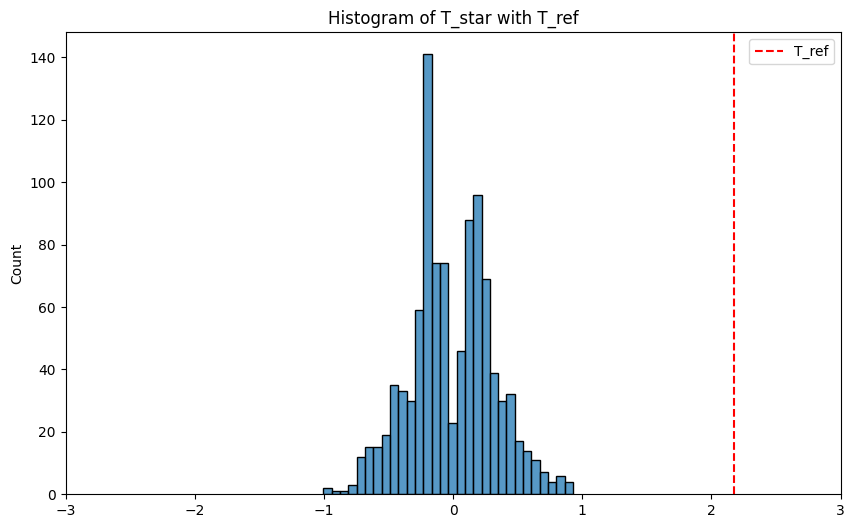

0.001998001998001998

In [4]:
#Some code proveded by the teacher
def get_maltose_dt(mrk):
    ''' For the given mark, returns the growth in Maltose'''
    # Filter the genotype DataFrame based on the marker
    genotype_filtered = genotype[genotype['marker'].isin([mrk])]

    # Merge the filtered genotype DataFrame with the growth DataFrame on 'strain'
    growth_mrk = pd.merge(growth, genotype_filtered[['strain', 'genotype', 'marker']], on='strain', how='outer')

    # Filter the merged DataFrame to include only rows where media is "YPMalt"
    return growth_mrk[growth_mrk['media'] == "YPMalt"]

def plot_growth_one_mk(mk):
    ''' Plotting boxplot'''
    # Get the filtered DataFrame for the given marker
    data = get_maltose_dt(mk)

    # Create a boxplot using seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='genotype', y='growth_rate', data=data)

    # Add a title and set the theme
    plt.title(mk)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def median_diff(df):
    """Function to calculate the difference of the medians of two genotypes"""
    wild_isolate_median = df[df['genotype'] == 'Wild isolate']['growth_rate'].median()
    lab_strain_median = df[df['genotype'] == 'Lab strain']['growth_rate'].median()
    return wild_isolate_median - lab_strain_median

def p_val_medians(df, N_permu=1000):
    """ Function to permute the table, plot the resulting histogram, and compute a p-value"""
    # Calculate the reference difference in medians
    T_ref = median_diff(df)

    # Generate T_star by permuting genotypes
    T_star = []
    for _ in range(N_permu):
        df.loc[:,'genotype'] = np.random.permutation(df.loc[:,'genotype'])
        T_star.append(median_diff(df))

    # Convert T_star to a numpy array for easier calculations
    T_star = np.array(T_star)

    # Plot the histogram of T_star with a vertical line at T_ref
    plt.figure(figsize=(10, 6))
    sns.histplot(T_star, kde=False, bins=30)
    plt.axvline(x=T_ref, color='red', linestyle='--', label='T_ref')
    plt.xlim(-3, 3)
    plt.legend()
    plt.title('Histogram of T_star with T_ref')
    plt.show()

    # Compute the p-value for each tail
    p_val_right = (np.sum(T_star >= T_ref) + 1) / (N_permu + 1)
    p_val_left = (np.sum(T_star <= T_ref) + 1) / (N_permu + 1)

    p_val = 2 * min(p_val_right, p_val_left)

    return p_val

We found that marker 5211 and marker 5091 are associated with growth. However, we also found that
both markers are associated with each other. Thus, the association of one of these markers with growth could
be explained away by the association of the other one with growth.
Now, we would like to know if marker 5091 still associates with growth in maltose (YPMalt) when conditioned
on marker 5211.


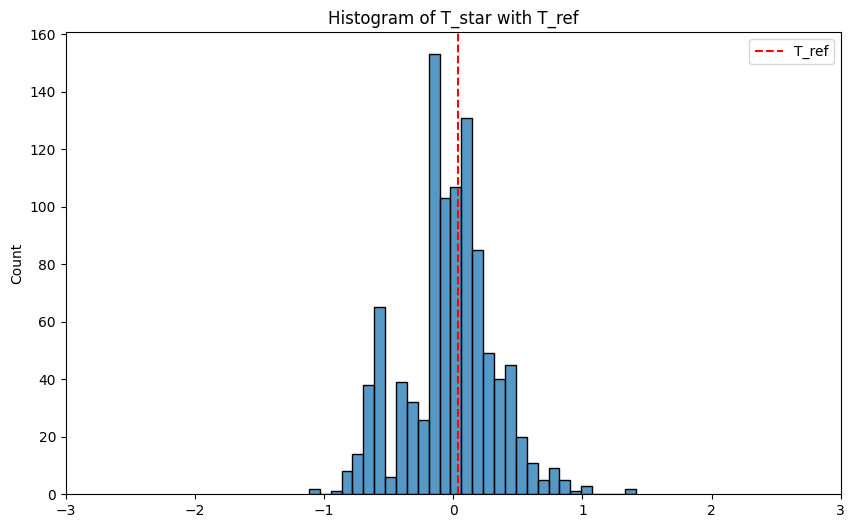

1.026973026973027

In [8]:
# Plan: get the strains where mrk_5211 is wild and study whether differences in mrk_5091 lead to any difference in growth
dt_5211=get_maltose_dt('mrk_5211')
dt_5091=get_maltose_dt('mrk_5091')

# Get a series of the strains where 5211 is wild
wild_5211 = dt_5211[dt_5211.genotype=='Wild isolate'].strain

# Filter the strains in dt_5091 where we know mrk_5211 is wild
selected_5091 = dt_5091[dt_5091.strain.isin(wild_5211)]

# Compare the median growth of the selected strains where 5211 is wild against where it is lab originated
p_val_medians(selected_5091)

In [ ]:
Now, test if marker 5211 associates with growth in maltose when conditioned on marker 5091. Are the
results the same?

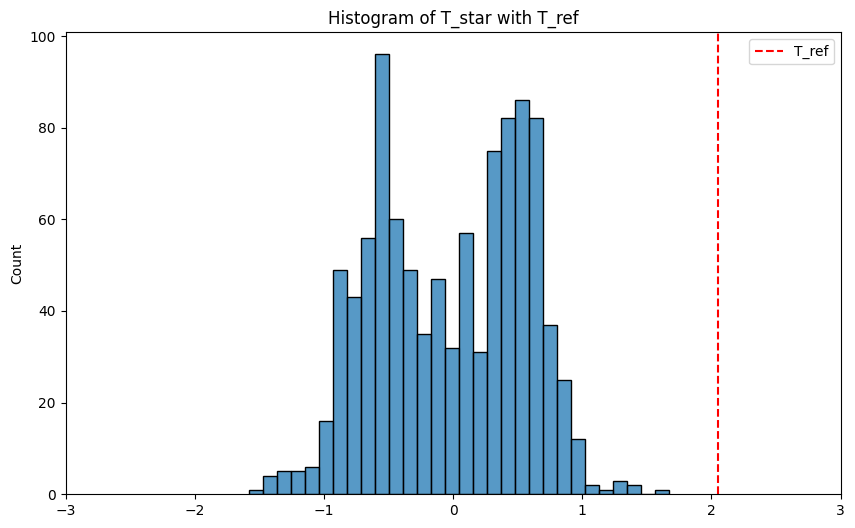

0.001998001998001998

In [6]:
# Plan: get the strains where mrk_5091 is wild and study whether differences in mrk_5211 lead to any difference in growth
dt_5211=get_maltose_dt('mrk_5211')
dt_5091=get_maltose_dt('mrk_5091')

# Get a series of the strains where 5091 is wild
wild_5091 = dt_5091[dt_5091.genotype=='Wild isolate'].strain

# Filter the strains in dt_5211 where we know mrk_5091 is wild
selected_5211 = dt_5211[dt_5211.strain.isin(wild_5091)]

# Compare the median growth of the selected strains where 5211 is wild against where it is lab originated
p_val_medians(selected_5211)

Estimate 95% equi-tailed confidence intervals for the difference of the medians of growth in maltose for each
genotype at marker mrk_5211. Use the case resampling bootstrap scheme and report bootstrap percentile
intervals. Propose a visualization of the results. Try it also with markers 5091 and 1653.

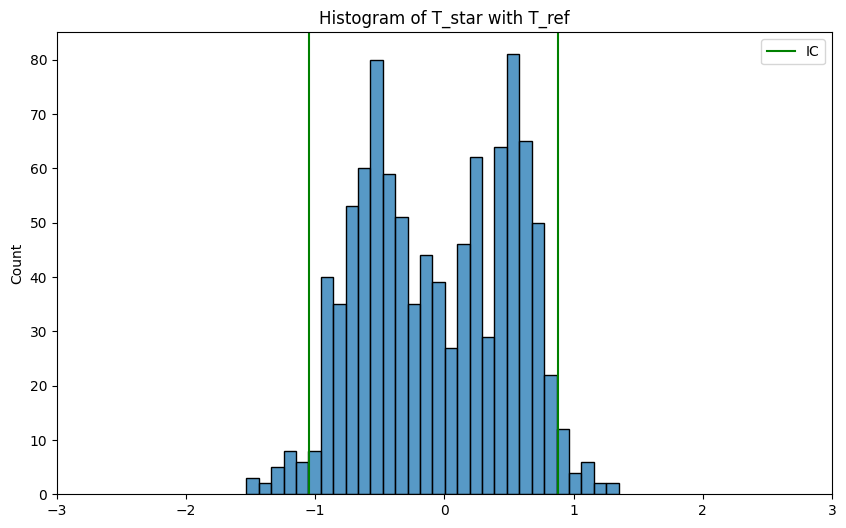

(0.8762162884420392, -1.0497633016690324)

In [7]:
def medians_IC(df, N_permu=1000):
    """ Function to permute the table, plot the resulting histogram, and compute the confidence interval"""
    # Calculate the reference difference in medians
    T_ref = median_diff(df)

    # Generate T_star by permuting genotypes
    T_star = []
    for _ in range(N_permu):
        df.loc[:,'genotype'] = np.random.permutation(df.loc[:,'genotype'])
        T_star.append(median_diff(df))

    # Convert T_star to a numpy array for easier calculations
    T_star = np.array(T_star)

    IC_bigger = np.percentile(T_star, 97.5)
    IC_smaller = np.percentile(T_star, 2.5)

    # Plot the histogram of T_star with a vertical line at T_ref
    plt.figure(figsize=(10, 6))
    sns.histplot(T_star, bins=30)

    # Lines indicating the IC values
    plt.axvline(x=IC_bigger, color='green', linestyle='-', label='IC')
    plt.axvline(x=IC_smaller, color='green', linestyle='-')

    plt.xlim(-3, 3)
    plt.legend()
    plt.title('Histogram of T_star with T_ref')
    plt.show()

    return IC_bigger, IC_smaller
medians_IC(selected_5211)